# VM: Deep Learning mit Python

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

In [6]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [39]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [8]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

**Loading data**

In [9]:
data = np.load('../data/train.npz')
bands = data['bands']
lulc = data['lulc'] #labels for central pixel of patches (Land Use and Land Cover)
#print(bands.shape)
#print(lulc.shape)

Channels from patch no. 250
Central pixel is labeled as Cultivated Land


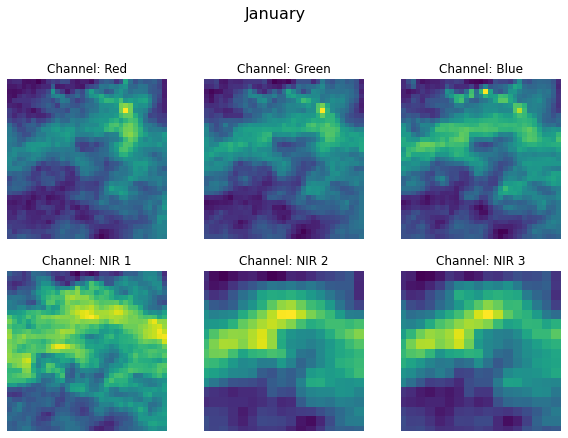

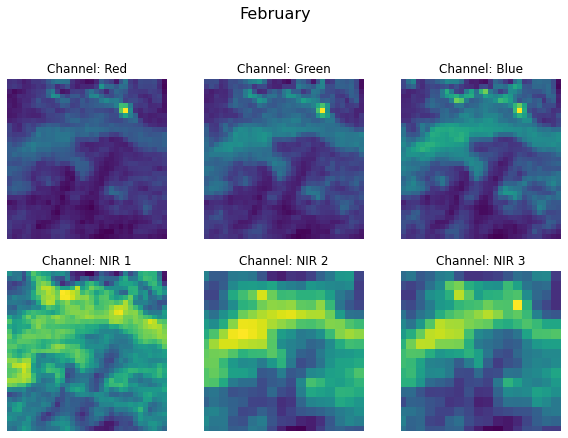

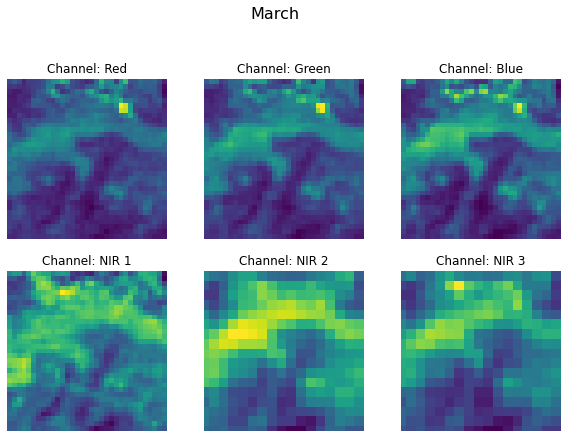

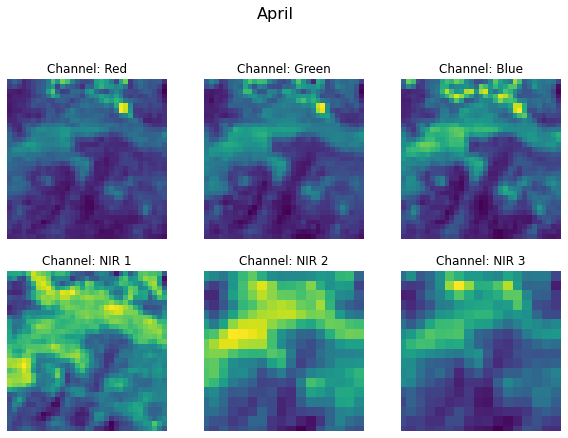

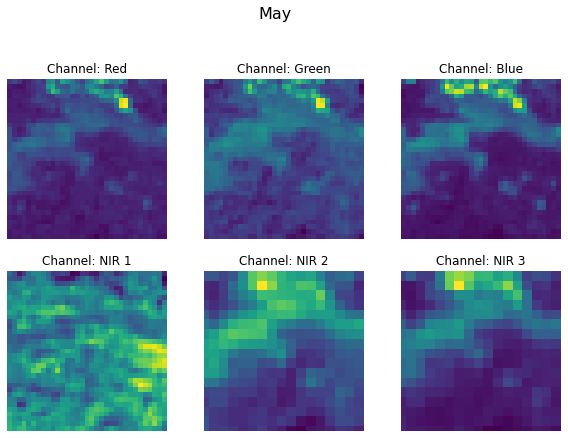

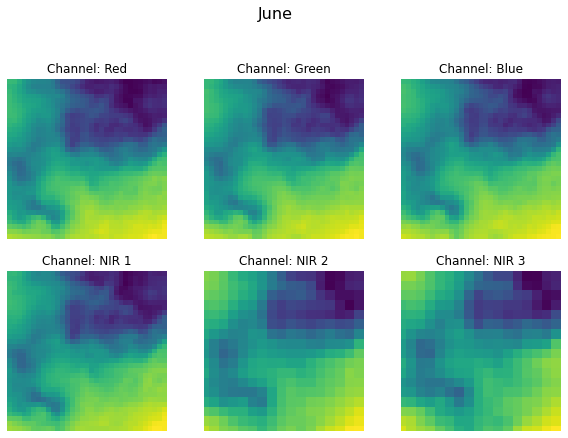

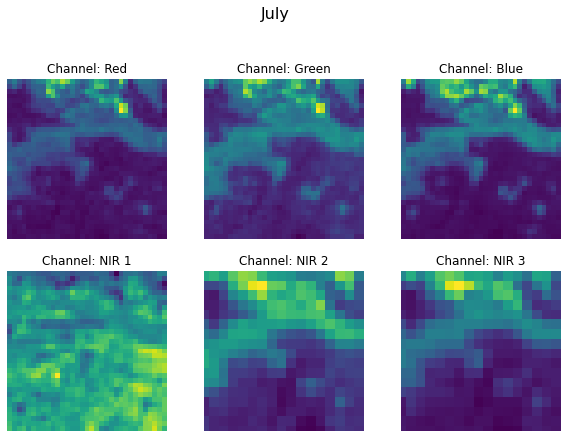

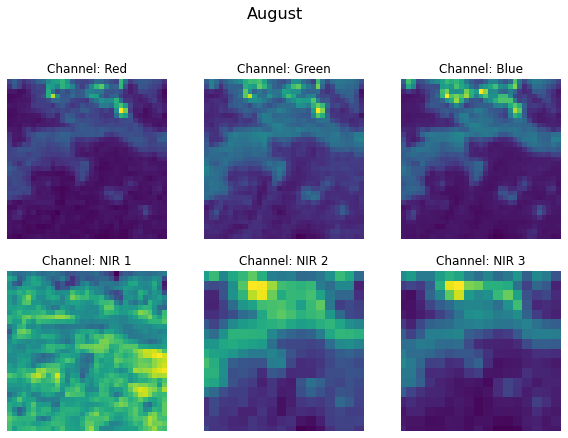

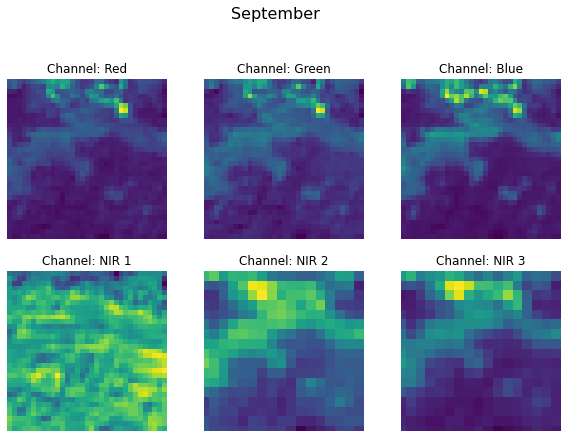

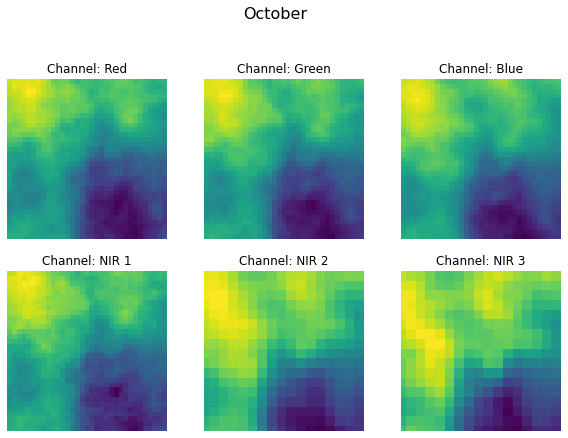

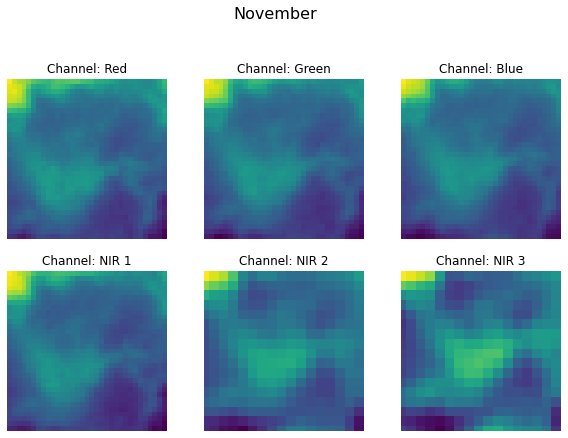

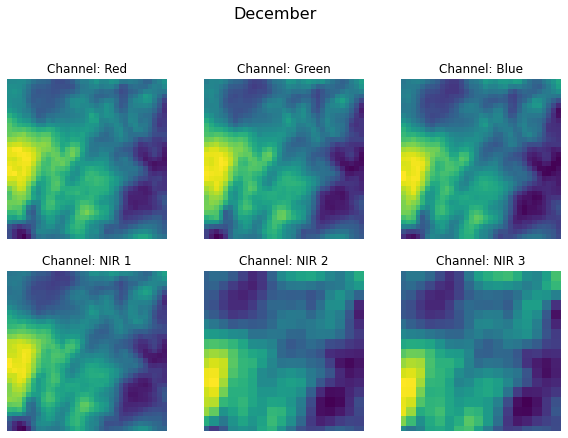

In [10]:
# Show some images

patch = 250

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Preprocessing**

In [11]:
# Generating test, validation and training sets
X = bands
y = lulc
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)

**Build the 3D CNN Model**

code by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [45]:
model = Sequential() # sequential model
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 10, 31, 31, 32)    5216      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 5, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 15, 15, 32)     128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 15, 15, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 3, 13, 13, 64)     55360     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 1, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 6, 6, 64)      

In [32]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
200/200 [==============================] - 375s 2s/step - loss: 1.6380 - accuracy: 0.5324 - val_loss: 1.9914 - val_accuracy: 0.5856
Epoch 2/5
200/200 [==============================] - 385s 2s/step - loss: 1.0626 - accuracy: 0.6396 - val_loss: 1.5205 - val_accuracy: 0.5975
Epoch 3/5
200/200 [==============================] - 462s 2s/step - loss: 0.9599 - accuracy: 0.6645 - val_loss: 1.2040 - val_accuracy: 0.6231
Epoch 4/5
200/200 [==============================] - 381s 2s/step - loss: 0.8340 - accuracy: 0.7109 - val_loss: 1.1572 - val_accuracy: 0.6456
Epoch 5/5
200/200 [==============================] - 411s 2s/step - loss: 0.7943 - accuracy: 0.7231 - val_loss: 0.8540 - val_accuracy: 0.7044


In [33]:
model.save('trainingData_5Epochs.h5') # save model in root directory
#keras.models.load_model('trainingData_5Epochs.h5')

**Evaluation**

63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990


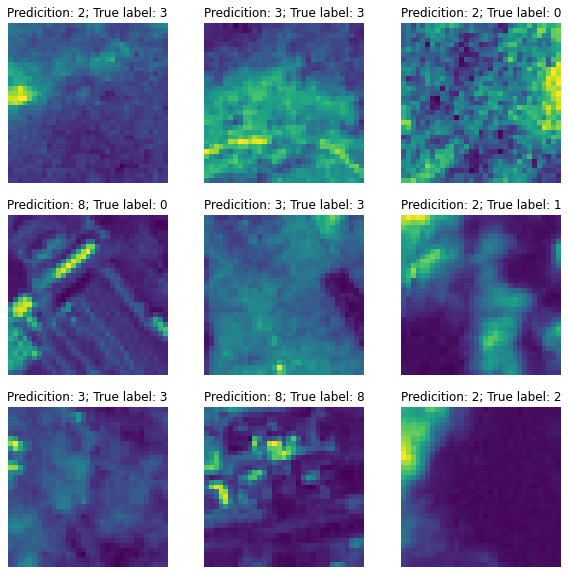

In [44]:
# Calculate loss and accuracy
model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[i, 0, :, :, 0])
  plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
  plt.axis("off")

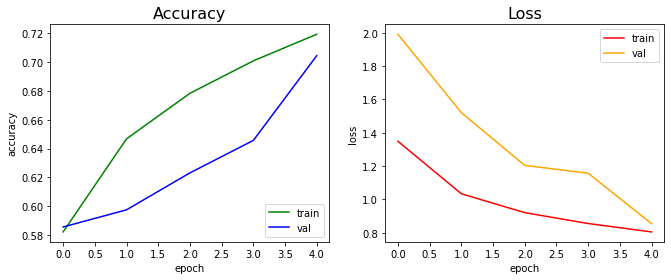

In [35]:
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()